In [1]:
from sqlalchemy import create_engine
from sqlalchemy.sql import text
import os
import pandas as pd
import numpy as np
import geopandas as gpd
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Functions

In [13]:
## Function of SEIR model.
## Function that takes in the above, maps out the figures appropriately.
## It's unclear if this is the actual best model or something alot more sophisticated is used.

def seir(y, t, n, alpha, beta, gamma):
    """
    y = initial vector of susceptible, infected, exposed, and removed/recovered
    t = time in days
    n = the population
    alpha = incubation period
    beta = effected contact rate - you would consider this the r0
    gamma = infectious period - imperial is 4.6
    
    This will return s, e, i, r so assign the return lists to variables of the same name.
    """
    def df_e(y, t, n, alpha, beta, gamma):
        ## Once we know where the first cases in Warwickshire were.
        ## Can tailor the contact rate. for instance
#         t > 16:
#             beta = 0.62 
        s, e, i, r = y
        dS_dt = -beta * s * i / n
        dE_dt = beta * s * i / n - alpha * e
        dI_dt = alpha * e - gamma * i
        dR_dt = gamma * i
        return dS_dt, dE_dt, dI_dt, dR_dt
    ret = odeint(df_e, y, t, args=(n, alpha, beta, gamma))
    return ret.T

def seir_timeseries_and_summed(df, geography_column_name, f_index, l_index):
    """
    The df is assumed to be a typical index. If using a groupby, you'll need to reset index.
    
    Take a df and the geography code to work from and output, a dictionary of time series.
    The return will be seir_dfs which is a dictionary of the geography code, the age groups
    and then a dataframe of the time series.
    
    It will return a second value, which is a summarised dataframe of the first.
    
    df : Takes the specified df, assumes the column is 0 for the geography.
    
    
    f_index : First position of age group.
    l_index : The last position remembering that list exclude last position, so upto
    """
    # Create nested dictionary, with the dataframes of each group added with the time series data.
    seir_dfs = {}
    for code in df.iloc[:, 0]:
        seir_dfs[code] = {df.columns[f_index+x]: pd.DataFrame() for x in range(len(df.columns[f_index:l_index]))}   

    ## Working on summing
    seir_summed_df = pd.DataFrame({geography_column_name: df.iloc[:, 0]})
    ## This could be added into the for loop below. However, the code is already not great to read
    ## The key difference is seir_dfs, creates the time series, as dataframes solely of time
    ## Where as seir_summed_df creates a single table of summed figures matching to lsoa.
    for x in range(len(df.columns[f_index:l_index])):
        seir_summed_df[df.columns[f_index+x] + '_scrh_imperial_2.4_sum'] = np.arange(len(df.iloc[:, 0]))
        seir_summed_df[df.columns[f_index+x] + '_hcrcc_imperial_2.4_sum'] = np.arange(len(df.iloc[:, 0]))
        seir_summed_df[df.columns[f_index+x] + '_ifr_imperial_2.4_sum'] = np.arange(len(df.iloc[:, 0]))
        seir_summed_df[df.columns[f_index+x] + '_scrh_cmmid_0.62_sum'] = np.arange(len(df.iloc[:, 0]))
        seir_summed_df[df.columns[f_index+x] + '_hcrcc_cmmid_0.62_sum'] = np.arange(len(df.iloc[:, 0]))
        seir_summed_df[df.columns[f_index+x] + '_ifr_cmmid_0.62_sum'] = np.arange(len(df.iloc[:, 0]))


    for _ in range(len(df.columns[f_index:l_index])):
        for row in range(len(df.iloc[:,f_index + _])):
            ## n in this instance is the sample/population and not a throwaway variable!
            n = df.iloc[row, f_index+_]
            #initial infection
            i_0 = 1
            # exposed and removed
            e_0 = 1
            r_0 = 0
            # susceptible to infection initially
            s_0 = n - i_0 - e_0 - r_0
            y_0 = s_0, e_0, i_0, r_0
            #alpha = incubation - imperial is 5.1
            alpha = 1./5.1
            # beta effected contact rate - imperial is 2.4
            beta = 2.4
            # gamma infectious period - imperial is 4.6
            gamma = 1./4.6
            # time (in days)
            t = np.linspace(0, 200, 200)
            ## get the value of row n from column i - n is the population these will return lists
            ## note the spread of how this looks.
            s, e, i, r = seir(y_0, t, n, alpha, beta, gamma)
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_s_imperial_2.4'] = s
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_e_imperial_2.4'] = e
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_i_imperial_2.4'] = i
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_r_imperial_2.4'] = r
            ## Bring in age_params_df now
            ## cases symptomatic is assumed .66
            cs = age_params_df.iloc[_, 1]
            # symptomatic cases requiring hospitalisation
            scrh = i * cs * age_params_df.iloc[_, 2]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_scrh_imperial_2.4'] = scrh
            # hospitalised cases requiring critical care
            hcrcc = scrh * age_params_df.iloc[_, 3]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_hcrcc_imperial_2.4'] = hcrcc
            # infection fatality ratio from hcrrc only
            ifr = hcrcc * age_params_df.iloc[_, 4]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_ifr_imperial_2.4'] = ifr

            # add to the summed df
            seir_summed_df.loc[row, df.columns[f_index+_] + '_scrh_imperial_2.4_sum'] = scrh.sum()
            seir_summed_df.loc[row, df.columns[f_index+_] + '_hcrcc_imperial_2.4_sum'] = hcrcc.sum()
            seir_summed_df.loc[row, df.columns[f_index+_] + '_ifr_imperial_2.4_sum'] = ifr.sum()

            ## Add the Centre for Mathematical Modelling of Infectious disease paper
            ## "Impact of physical distance measures on transmission in the UK"
            i_1 = 1
            # exposed and removed
            e_1 = 1
            r_1 = 0
            # susceptible to infection initially
            s_1 = n - i_1 - e_1 - r_1
            y_1 = s_1, e_1, i_1, r_1
            #alpha = incubation - imperial is 5.1
            alpha = 1./5.1
            # beta effected contact rate - imperial is 2.4
            beta = 0.62
            # gamma infectious period - imperial is 4.6
            gamma = 1./4.6
            # time (in days)
            t = np.linspace(0, 200, 200)
            ## get the value of row n from column _ - n is the population these will return lists
            ## note the spread of how this looks.
            s, e, i, r = seir(y_1, t, n, alpha, beta, gamma)
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_s_cmmid_0.62'] = s
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_e_cmmid_0.62'] = e
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_i_cmmid_0.62'] = i
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_r_cmmid_0.62'] = r
            ## Bring in age_params_df now
            ## cases symptomatic is assumed .66
            cs = age_params_df.iloc[_, 1]
            # symptomatic cases requiring hospitalisation
            scrh = i * cs * age_params_df.iloc[_, 2]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_scrh_cmmid_0.62'] = scrh
            # hospitalised cases requiring critical care
            hcrcc = scrh * age_params_df.iloc[_, 3]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_hcrcc_cmmid_0.62'] = hcrcc
            # infection fatality ratio from hcrrc only
            ifr = hcrcc * age_params_df.iloc[_, 4]
            seir_dfs[df.iloc[row, 0]][df.columns[f_index+_]][df.columns[f_index+_] + '_ifr_cmmid_0.62'] = ifr

            #add to the summed df
            seir_summed_df.loc[row, df.columns[f_index+_] + '_scrh_cmmid_0.62_sum'] = scrh.sum()
            seir_summed_df.loc[row, df.columns[f_index+_] + '_hcrcc_cmmid_0.62_sum'] = hcrcc.sum()
            seir_summed_df.loc[row, df.columns[f_index+_] + '_ifr_cmmid_0.62_sum'] = ifr.sum()

    return seir_dfs, seir_summed_df

# Load data

In [23]:
## Age, symptomatic, hospitalisation, critical, and Infection Fatality Ratio
age_params_df = pd.read_excel('data/parameters_age.xlsx')
age_params_df.head(10)

,Age Band,% of Cases Symptomatic,% symptomatic cases requiring hospitalisation,% hospitalised cases requiring critical care,Infection Fatality Ratio,Redution Due to Full Intervention
0,0-9,0.66,0.001,0.050,0.00002,0.33
1,10-19,0.66,0.003,0.050,0.00006,0.33
2,20-29,0.66,0.012,0.050,0.00003,0.33
3,30-39,0.66,0.032,0.050,0.00080,0.33
4,40-49,0.66,0.049,0.063,0.00150,0.33
5,50-59,0.66,0.102,0.122,0.00600,0.33
6,60-69,0.66,0.166,0.274,0.02200,0.33
7,70-79,0.66,0.243,0.432,0.05100,0.33
8,80+,0.66,0.273,0.709,0.09300,0.33


In [5]:
# Connect to the POSTGIS Database
user = os.environ['WCC_USER'].lower()
pw = os.environ['POSTGIS_PW']
postgis = os.environ['POSTGIS_DB_REST_OF_CONN']
# connection string
engine = create_engine('postgresql://' + user +  ':' + pw + postgis,
                      connect_args={'sslmode':'require'})
conn = engine.connect()
q = """
SELECT lsoa.code AS lsoa_code,
lsoa.name AS lsoa_name,
wcc_local.local_name AS lsoa_local_name,
lsoa.area AS lsoa_area,
lsoa.lengths AS lsoa_lengths,
lsoa.geom AS lsoa_geom,
-- add EPSG426
ST_Transform(lsoa.geom, 4326) AS lsoa_long_lat_geom,
ST_ASText(ST_Transform(lsoa.geom, 4326)) AS lsoa_long_lat_text,
ccg.ccg_id,
ccg.ccg_name,
--note spelling error in column below
ccg.cch_hq_location AS ccg_hq_location,
ccg.geom AS ccg_geom,
ST_Transform(ccg.geom, 4326) AS ccg_long_lat_geom,
ST_ASText(ST_Transform(ccg.geom, 4326)) AS ccg_long_lat_text,
district_borough.district_borough_name,
district_borough.district_borough_code,
district_borough.geom AS district_borough_geom,
ST_Transform(district_borough.geom, 4326) AS district_borough_long_lat_geom,
ST_ASText(ST_Transform(district_borough.geom, 4326)) AS district_borough_long_lat_text,
jsna.jsna_id,
jsna.jsna_name,
--exclude jsna_pop_2017 latest figures will be built from mid-year 2018
jsna.geom AS jsna_geom,
ST_Transform(jsna.geom, 4326) AS jsna_long_lat_geom,
ST_ASText(ST_Transform(jsna.geom, 4326)) AS jsna_long_lat_text,
msoa.msoa_code,
msoa.msoa_name,
msoa.geom AS msoa_geom,
ST_Transform(msoa.geom, 4326) AS msoa_long_lat_geom,
ST_ASText(ST_Transform(msoa.geom, 4326)) AS msoa_long_lat_text,
ward.code AS ward_code,
ward.name AS ward_name,
ward.geom AS ward_geom,
ST_Transform(ward.geom, 4326) AS ward_long_lat_geom,
ST_ASText(ST_Transform(ward.geom, 4326)) AS ward_long_lat_text
FROM admin_boundaries.lsoa_boundaries_great_britain_polygon lsoa
LEFT JOIN admin_boundaries.ccg_areas_warwickshire_coventry_polygon ccg
ON ST_Contains(ccg.geom, ST_Centroid(lsoa.geom))
LEFT JOIN admin_boundaries.lsoa_boundaries_warwickshire_polygon wcc_local
ON lsoa.code = wcc_local.code
LEFT JOIN admin_boundaries.districts_boroughs_boundaries_warwickshire_polygon district_borough
ON ST_Contains(district_borough.geom, ST_Centroid(wcc_local.geom))
LEFT JOIN admin_boundaries.jsna_warwickshire_polygon jsna
ON ST_Contains(jsna.geom, ST_Centroid(wcc_local.geom))
LEFT JOIN admin_boundaries.msoa_boundaries_warwickshire_polygon msoa
ON ST_Contains(msoa.geom, ST_Centroid(wcc_local.geom))
LEFT JOIN admin_boundaries.ward_boundaries_great_britain_polygon ward
ON ST_Contains(ward.geom, ST_Centroid(lsoa.geom))
WHERE ST_Contains(ccg.geom, ST_Centroid(lsoa.geom))
"""

polygon_df = pd.read_sql(q, conn)

In [ ]:
polygon_df.head()

In [ ]:
oa_df = gpd.read_file('data/oa_shapefile/Output_Areas_December_2011_Boundaries_EW_BFE.shp')
oa_df.head()

In [8]:
## Read in excel file with OA
ages_df = pd.read_excel('data/SAPE21DT10e-mid-2018-coa-unformatted-syoa-estimates-west-midlands.xlsx',
                            sheet_name='Mid-2018 Persons',
                           skiprows=4)
ages_df.head()

,OA11CD,LSOA11CD,All Ages,0,1,2,3,4,5,6,...,81,82,83,84,85,86,87,88,89,90+
0,E00045110,E01008881,277,3,2,2,3,4,4,7,...,1,0,4,2,3,3,5,1,1,2
1,E00045113,E01008881,348,4,4,4,4,4,6,6,...,2,0,1,0,1,0,1,0,0,2
2,E00045116,E01008881,429,5,5,8,11,7,10,4,...,7,1,0,0,1,4,2,0,0,4
3,E00045118,E01008881,391,6,3,5,5,2,5,5,...,3,3,1,2,4,5,1,4,1,2
4,E00045123,E01008881,268,2,7,4,9,5,5,6,...,1,4,1,0,0,2,2,0,0,5


# Transformations

In [9]:
# create the new aggregated ages datasets.
x = 0
y = 10
new_data = {}
for i in range(9):
    l = [x for x in range(x, y)]
    new_data[f'{x}-{(y-1)}'] = ages_df[l].sum(axis=1)
    x += 10
    y += 10

#add in the 90+ category to the 80+
new_data['80+'] = new_data['80-89'] + ages_df['90+']
age_groups_df = pd.DataFrame(new_data)
#can now drop 80-89 since 80+ is created.
age_groups_df.drop('80-89', axis=1, inplace=True)
age_groups_df.head()

,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,37,32,24,39,25,34,26,35,25
1,56,66,47,52,41,44,27,8,7
2,76,88,59,43,57,44,30,11,21
3,44,66,61,49,33,54,32,24,28
4,48,21,36,39,23,50,13,20,18


In [10]:
ages_df = ages_df.merge(age_groups_df, left_index=True, right_index=True)
ages_df.head()

,OA11CD,LSOA11CD,All Ages,0,1,2,3,4,5,6,...,90+,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,E00045110,E01008881,277,3,2,2,3,4,4,7,...,2,37,32,24,39,25,34,26,35,25
1,E00045113,E01008881,348,4,4,4,4,4,6,6,...,2,56,66,47,52,41,44,27,8,7
2,E00045116,E01008881,429,5,5,8,11,7,10,4,...,4,76,88,59,43,57,44,30,11,21
3,E00045118,E01008881,391,6,3,5,5,2,5,5,...,2,44,66,61,49,33,54,32,24,28
4,E00045123,E01008881,268,2,7,4,9,5,5,6,...,5,48,21,36,39,23,50,13,20,18


In [11]:
column_drop_list = [x for x in range(90)]
column_drop_list += ['90+']
# print(column_drop_list)
ages_df = ages_df.drop(columns=column_drop_list)
ages_df.head()

,OA11CD,LSOA11CD,All Ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,E00045110,E01008881,277,37,32,24,39,25,34,26,35,25
1,E00045113,E01008881,348,56,66,47,52,41,44,27,8,7
2,E00045116,E01008881,429,76,88,59,43,57,44,30,11,21
3,E00045118,E01008881,391,44,66,61,49,33,54,32,24,28
4,E00045123,E01008881,268,48,21,36,39,23,50,13,20,18


In [15]:
df = ages_df.merge(oa_df, how='left', left_on='OA11CD', right_on='OA11CD')
df = polygon_df.merge(df, how='left', left_on='lsoa_code', right_on='LSOA11CD')
## Drop columns and rename some
df = df.drop(columns=['LSOA11CD', 'FID'])
df = df.rename(columns={"LAD11CD": "local_authority_code",
                   "Shape__Are": "oa_area",
                   "Shape__Len": "oa_length",
                   "geometry": "oa_long_lat_text",
                   "OA11CD": "oa_code",
                       "All Ages": 'all_ages'})
## Reorder the columns, so the other code reads from the same area.
df = df[['oa_code',
         'oa_long_lat_text',
         'local_authority_code',
         'lsoa_code',
         'lsoa_name',
         'lsoa_local_name',
         'lsoa_area',
         'lsoa_lengths',
         'lsoa_geom',
         'lsoa_long_lat_geom',
         'lsoa_long_lat_text',
         'ccg_id',
         'ccg_name',
         'ccg_hq_location',
         'ccg_geom',
         'ccg_long_lat_geom',
         'ccg_long_lat_text',
         'district_borough_name',
         'district_borough_code',
         'district_borough_geom',
         'district_borough_long_lat_geom',
         'district_borough_long_lat_text',
         'jsna_id',
         'jsna_name',
         'jsna_geom',
         'jsna_long_lat_geom',
         'jsna_long_lat_text',
         'msoa_code',
         'msoa_name',
         'msoa_geom',
         'msoa_long_lat_geom',
         'msoa_long_lat_text',
         'ward_code',
         'ward_name',
         'ward_geom',
         'ward_long_lat_geom',
         'ward_long_lat_text',
         'all_ages',
         '0-9',
         '10-19',
         '20-29',
         '30-39',
         '40-49',
         '50-59',
         '60-69',
         '70-79',
         '80+',
         'oa_area',
         'oa_length'
        ]]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2832 entries, 0 to 2831
Data columns (total 49 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   oa_code                         2832 non-null   object  
 1   oa_long_lat_text                2832 non-null   geometry
 2   local_authority_code            2832 non-null   object  
 3   lsoa_code                       2832 non-null   object  
 4   lsoa_name                       2832 non-null   object  
 5   lsoa_local_name                 1818 non-null   object  
 6   lsoa_area                       2832 non-null   float64 
 7   lsoa_lengths                    2832 non-null   float64 
 8   lsoa_geom                       2832 non-null   object  
 9   lsoa_long_lat_geom              2832 non-null   object  
 10  lsoa_long_lat_text              2832 non-null   object  
 11  ccg_id                          2832 non-null   object  
 12  ccg_name            

In [22]:
# sense check

# figure for ccg should come out to 2832
print(df['ccg_name'].value_counts(dropna=True).sum())
# figure should be 2832
print(df['lsoa_name'].value_counts(dropna=True).sum())
# local_authority_code is not inclusive of Warwickshire County Council - figure should be 2832
print(df['local_authority_code'].value_counts(dropna=True).sum())
# 2832
print(df['ward_name'].value_counts(dropna=True).sum())
# figures should be 1818
print(df['msoa_name'].value_counts(dropna=True).sum())
print(df['jsna_name'].value_counts(dropna=True).sum())


2832
2832
2832
2832
1818
1818


In [24]:
oa_seir_dfs, oa_seir_summed_df = seir_timeseries_and_summed(df, 'oa_code', 38, 47)

/home/tfos1/covid19/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars
/home/tfos1/covid19/venv/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in double_scalars
/home/tfos1/covid19/venv/lib/python3.6/site-packages/scipy/integrate/odepack.py:248: ODEintWarning: Illegal input detected (internal error). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


# Perform Groupby operations to match at (data is already at OA level):
    * LSOA
    * MSOA
    * Ward
    * District/Borough and City
    * CCG
    * Warwickshire only

In [27]:
drop_columns = ['lsoa_area', 'lsoa_lengths', 'oa_area', 'oa_length']

## LSOA

In [43]:
grouped_lsoa_df = df.groupby(['lsoa_code']).sum()
grouped_lsoa_df = grouped_lsoa_df.drop(columns=drop_columns)
grouped_lsoa_df.reset_index(inplace=True)
grouped_lsoa_df.head()

,lsoa_code,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,E01009522,1464,209,176,173,159,164,165,157,185,76
1,E01009523,1504,107,132,153,105,185,245,178,259,140
2,E01009524,1705,180,217,205,187,210,233,217,150,106
3,E01009525,1486,152,166,158,205,173,211,185,127,109
4,E01009526,1611,200,173,177,201,202,210,171,182,95


In [29]:
grouped_lsoa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 534 entries, 0 to 533
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   lsoa_code  534 non-null    object
 1   all_ages   534 non-null    int64 
 2   0-9        534 non-null    int64 
 3   10-19      534 non-null    int64 
 4   20-29      534 non-null    int64 
 5   30-39      534 non-null    int64 
 6   40-49      534 non-null    int64 
 7   50-59      534 non-null    int64 
 8   60-69      534 non-null    int64 
 9   70-79      534 non-null    int64 
 10  80+        534 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 46.0+ KB


## MSOA

In [30]:
grouped_msoa_df = df.groupby(['msoa_code']).sum()
grouped_msoa_df = grouped_msoa_df.drop(columns=drop_columns)
grouped_msoa_df.reset_index(inplace=True)
grouped_msoa_df.head()

,msoa_code,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,E02006468,10794,1122,1232,1084,1161,1483,1605,1347,1193,567
1,E02006469,9154,1110,1087,1009,1186,1158,1378,1033,772,421
2,E02006470,11968,1444,1264,1443,1378,1496,1677,1420,1143,703
3,E02006471,6963,609,660,672,696,891,1155,1078,870,332
4,E02006472,9415,1057,1029,996,1063,1270,1483,1146,909,462


In [31]:
grouped_msoa_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   msoa_code  66 non-null     object
 1   all_ages   66 non-null     int64 
 2   0-9        66 non-null     int64 
 3   10-19      66 non-null     int64 
 4   20-29      66 non-null     int64 
 5   30-39      66 non-null     int64 
 6   40-49      66 non-null     int64 
 7   50-59      66 non-null     int64 
 8   60-69      66 non-null     int64 
 9   70-79      66 non-null     int64 
 10  80+        66 non-null     int64 
dtypes: int64(10), object(1)
memory usage: 5.8+ KB


## Ward

In [32]:
grouped_ward_df = df.groupby(['ward_code']).sum()
grouped_ward_df = grouped_ward_df.drop(columns=drop_columns)
grouped_ward_df.reset_index(inplace=True)
grouped_ward_df.head()

,ward_code,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,E05001218,17683,2112,1958,2171,2181,2252,2366,1883,1744,1016
1,E05001219,17704,2431,1996,2467,2568,1955,2214,1720,1446,907
2,E05001220,18377,2375,1635,2935,3166,2145,2024,1652,1393,1052
3,E05001221,15467,1422,1618,2530,1762,1988,2080,1782,1374,911
4,E05001222,25259,4719,3457,5006,4599,3032,1957,1270,765,454


In [33]:
grouped_ward_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 124 entries, 0 to 123
Data columns (total 11 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   ward_code  124 non-null    object
 1   all_ages   124 non-null    int64 
 2   0-9        124 non-null    int64 
 3   10-19      124 non-null    int64 
 4   20-29      124 non-null    int64 
 5   30-39      124 non-null    int64 
 6   40-49      124 non-null    int64 
 7   50-59      124 non-null    int64 
 8   60-69      124 non-null    int64 
 9   70-79      124 non-null    int64 
 10  80+        124 non-null    int64 
dtypes: int64(10), object(1)
memory usage: 10.8+ KB


## District, Borough and City

In [34]:
grouped_district_df = df.groupby(['local_authority_code']).sum()
grouped_district_df = grouped_district_df.drop(columns=drop_columns)
grouped_district_df.reset_index(inplace=True)
# will return 6 in the data as coventry included!
grouped_district_df.head(6)

,local_authority_code,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,E07000218,64850,7065,6823,6986,7311,8457,9962,8115,6581,3550
1,E07000219,128902,16251,14327,15095,16731,16378,17973,14548,11484,6115
2,E07000220,107194,13572,12631,11189,14407,14677,14777,10852,9485,5604
3,E07000221,127580,12893,13387,11863,12918,16287,19576,16551,14986,9119
4,E07000222,142484,15545,15525,23901,16662,18339,18495,14412,11905,7700
5,E08000026,366785,47239,44284,78477,52882,40565,38290,28549,22413,14086


In [35]:
grouped_district_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   local_authority_code  6 non-null      object
 1   all_ages              6 non-null      int64 
 2   0-9                   6 non-null      int64 
 3   10-19                 6 non-null      int64 
 4   20-29                 6 non-null      int64 
 5   30-39                 6 non-null      int64 
 6   40-49                 6 non-null      int64 
 7   50-59                 6 non-null      int64 
 8   60-69                 6 non-null      int64 
 9   70-79                 6 non-null      int64 
 10  80+                   6 non-null      int64 
dtypes: int64(10), object(1)
memory usage: 656.0+ bytes


## Coventry and Warwickshire CCGs

In [36]:
grouped_ccg_df = df.groupby(['ccg_name']).sum()
grouped_ccg_df = grouped_ccg_df.drop(columns=drop_columns)
grouped_ccg_df.reset_index(inplace=True)
grouped_ccg_df.head()

,ccg_name,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,Coventry & Rugby,473979,60811,56915,89666,67289,55242,53067,39401,31898,19690
1,South Warwickshire,270064,28438,28912,35764,29580,34626,38071,30963,26891,16819
2,Warwickshire North,193752,23316,21150,22081,24042,24835,27935,22663,18065,9665


In [37]:
grouped_ccg_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3 entries, 0 to 2
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   ccg_name  3 non-null      object
 1   all_ages  3 non-null      int64 
 2   0-9       3 non-null      int64 
 3   10-19     3 non-null      int64 
 4   20-29     3 non-null      int64 
 5   30-39     3 non-null      int64 
 6   40-49     3 non-null      int64 
 7   50-59     3 non-null      int64 
 8   60-69     3 non-null      int64 
 9   70-79     3 non-null      int64 
 10  80+       3 non-null      int64 
dtypes: int64(10), object(1)
memory usage: 392.0+ bytes


# Warwickshire only

In [40]:
grouped_wcc_df = df.groupby(['district_borough_name']).sum()
grouped_wcc_df = grouped_wcc_df.drop(columns=drop_columns)
grouped_wcc_df.reset_index(inplace=True)
# This creates a series.
grouped_wcc_df = pd.DataFrame(grouped_wcc_df.sum()).transpose()
grouped_wcc_df = grouped_wcc_df.rename(columns={'district_borough_name': 'County'})
grouped_wcc_df['County'] = "Warwickshire"
grouped_wcc_df.head()

,County,all_ages,0-9,10-19,20-29,30-39,40-49,50-59,60-69,70-79,80+
0,Warwickshire,571010,65326,62693,69034,68029,74138,80783,64478,54441,32088


In [41]:
grouped_wcc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   County    1 non-null      object
 1   all_ages  1 non-null      object
 2   0-9       1 non-null      object
 3   10-19     1 non-null      object
 4   20-29     1 non-null      object
 5   30-39     1 non-null      object
 6   40-49     1 non-null      object
 7   50-59     1 non-null      object
 8   60-69     1 non-null      object
 9   70-79     1 non-null      object
 10  80+       1 non-null      object
dtypes: object(11)
memory usage: 216.0+ bytes


In [ ]:
oa_seir_dfs, oa_seir_summed_df = seir_timeseries_and_summed(df, 'oa_code', 38, 47)


In [56]:
lsoa_seir_dfs, lsoa_seir_summed_df = seir_timeseries_and_summed(grouped_lsoa_df, 'lsoa_code', 2, 11)


In [57]:
msoa_seir_dfs, msoa_seir_summed_df = seir_timeseries_and_summed(grouped_msoa_df, 'msoa_code', 2, 11)


In [58]:
ward_seir_dfs, ward_seir_summed_df = seir_timeseries_and_summed(grouped_ward_df, 'ward_code', 2, 11)


In [59]:
district_seir_dfs, district_seir_summed_df = seir_timeseries_and_summed(grouped_district_df, 'local_authority_code', 2, 11)


In [60]:
ccg_seir_dfs, ccg_seir_summed_df = seir_timeseries_and_summed(grouped_ccg_df, 'ccg_name', 2, 11)


In [61]:
wcc_seir_dfs, wcc_seir_summed_df = seir_timeseries_and_summed(grouped_wcc_df, 'wcc', 2, 11)

In [62]:
timeseries = [
    oa_seir_dfs,
    lsoa_seir_dfs,
    msoa_seir_dfs,
    ward_seir_dfs,
    district_seir_dfs,
    ccg_seir_dfs,
    wcc_seir_dfs
]
summed_timeseries = [
    oa_seir_summed_df,
    lsoa_seir_summed_df,
    msoa_seir_summed_df,
    ward_seir_summed_df,
    district_seir_summed_df,
    ccg_seir_summed_df,
    wcc_seir_summed_df    
]

In [72]:
import copy
timeseries_copy = copy.deepcopy(timeseries)
summed_timeseries_copy = copy.deepcopy(summed_timeseries)

for ts in range(len(timeseries_copy)):
    for k, v in timeseries[ts].items():
        for v, age in v.items():
            timeseries_copy[ts][k][v] = timeseries_copy[ts][k][v].to_dict()

In [75]:
names = [
    'oa',
    'lsoa',
    'msoa',
    'ward',
    'district_borough_city',
    'ccg',
    'wcc'
]

import json
for index in range(len(names)):
    with open(f'all_geographies_output/{names[index]}_age_group_covid19_seir.json', 'w') as f:
        json.dump(timeseries_copy[index], f)
    summed_timeseries_copy[index].to_json(
        f'all_geographies_output/{names[index]}_age_group_covid19_seir_summed.json')

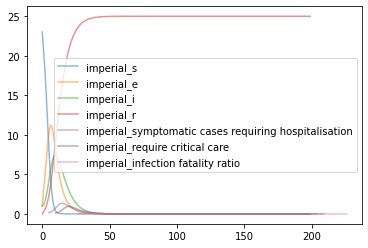

In [80]:
test_df = oa_seir_dfs['E00158888']['80+']
# plot

fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(test_df.index, test_df.iloc[:,0], alpha=0.5, label="imperial_s")
ax.plot(test_df.index, test_df.iloc[:,1], alpha=0.5, label="imperial_e")
ax.plot(test_df.index, test_df.iloc[:,2], alpha=0.5, label="imperial_i")
ax.plot(test_df.index, test_df.iloc[:,3], alpha=0.5, label="imperial_r")
ax.plot(test_df.index + 5, test_df.iloc[:,4], alpha=0.5, label="imperial_symptomatic cases requiring hospitalisation")
ax.plot(test_df.index + 10, test_df.iloc[:,5], alpha=0.5, label='imperial_require critical care')
ax.plot(test_df.index + 27, test_df.iloc[:,6], alpha=0.5, label='imperial_infection fatality ratio')
legend = ax.legend()
plt.show()




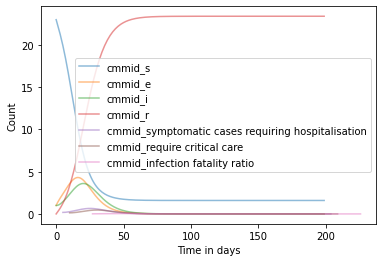

In [81]:
fig = plt.figure()
ax = fig.add_subplot(111, axisbelow=True)
ax.plot(test_df.index, test_df.iloc[:,7], alpha=0.5, label="cmmid_s")
ax.plot(test_df.index, test_df.iloc[:,8], alpha=0.5, label="cmmid_e")
ax.plot(test_df.index, test_df.iloc[:,9], alpha=0.5, label="cmmid_i")
ax.plot(test_df.index, test_df.iloc[:,10], alpha=0.5, label="cmmid_r")
ax.plot(test_df.index + 5, test_df.iloc[:,11], alpha=0.5, label="cmmid_symptomatic cases requiring hospitalisation")
ax.plot(test_df.index + 10, test_df.iloc[:,12], alpha=0.5, label='cmmid_require critical care')
ax.plot(test_df.index + 27, test_df.iloc[:,13], alpha=0.5, label='cmmid_infection fatality ratio')
ax.set_xlabel('Time in days')
ax.set_ylabel('Count')

legend = ax.legend()
plt.show()